# Example of Parseval's theorem

In [1]:
import numpy as np
import numpy.testing as npt
import xarray as xr
import xrft
import numpy.fft as npft
import dask.array as dsar
import matplotlib.pyplot as plt
%matplotlib inline

**First, we show that `xrft.fft` satisfies the Parseval's theorem exactly for a non-windowed signal**

For one-dimensional data:
$$\sum_x (da)^2 \Delta x = \sum_k \mathcal{F}(da)[\mathcal{F}(da)]^* \Delta k.$$

**Generate synthetic data**

In [2]:
Nx = 40
dx = np.random.rand()
da = xr.DataArray(
        np.random.rand(Nx) + 1j * np.random.rand(Nx),
        dims="x",
        coords={"x": dx * (np.arange(-Nx // 2, -Nx // 2 + Nx)
                           + np.random.randint(-Nx // 2, Nx // 2)
                          )
               },
                 )

In [3]:
###############
# Assert Parseval's using xrft.fft
###############
FT = xrft.fft(da, dim="x", true_phase=True, true_amplitude=True)
npt.assert_almost_equal(
        (np.abs(da) ** 2).sum() * dx, (np.abs(FT) ** 2).sum() * FT["freq_x"].spacing
                       )

###############
# Assert Parseval's using xrft.power_spectrum with scaling='density'
###############
ps = xrft.power_spectrum(da, dim="x")
npt.assert_almost_equal(
        ps.sum(),
        (np.abs(da) ** 2).sum() * dx
                       )

For two-dimensional data:
$$\sum_x \sum_y (da)^2 \Delta x \Delta y = \sum_k \sum_l \mathcal{F}(da)\mathcal{F}(da)^* \Delta k \Delta l.$$

**Generate synthetic data**

In [4]:
Ny = 60
dx, dy = (np.random.rand(), np.random.rand())
da2 = xr.DataArray(
        np.random.rand(Nx, Ny) + 1j * np.random.rand(Nx, Ny),
        dims=["x", "y"],
        coords={"x": dx
                * (
                    np.arange(-Nx // 2, -Nx // 2 + Nx)
                    + np.random.randint(-Nx // 2, Nx // 2)
                ),
                "y": dy
                * (
                    np.arange(-Ny // 2, -Ny // 2 + Ny)
                    + np.random.randint(-Ny // 2, Ny // 2)
                ),
              },
                  )

In [5]:
###############
# Assert Parseval's using xrft.fft
###############
FT2 = xrft.fft(da2, dim=["x", "y"], true_phase=True, true_amplitude=True)
npt.assert_almost_equal(
        (np.abs(FT2) ** 2).sum() * FT2["freq_x"].spacing * FT2["freq_y"].spacing,
        (np.abs(da2) ** 2).sum() * dx * dy,
                       )

###############
# Assert Parseval's using xrft.power_spectrum with scaling='density'
###############
ps2 = xrft.power_spectrum(da2, dim=["x", "y"])
npt.assert_almost_equal(
        ps2.sum(),
        (np.abs(da2) ** 2).sum() * dx * dy
                       )

###############
# Assert Parseval's using xrft.power_spectrum with scaling='spectrum'
###############
ps2 = xrft.power_spectrum(da2, dim=["x", "y"], scaling='spectrum')
npt.assert_almost_equal(
        ps2.sum() / (ps2.freq_x.spacing * ps2.freq_y.spacing),
        (np.abs(da2) ** 2).sum() * dx * dy,
                       )

**Now, we show how Parseval's theorem is approximately satisfied for windowed data**
$$\frac{1}{\langle w^2\rangle} \sum_x (w\ da)^2 \Delta x = \sum_x (da)^2 \Delta x \approx \frac{1}{\langle w^2\rangle} \sum_k \mathcal{F}(w)\circ\mathcal{F}(da)[\mathcal{F}(w)\circ\mathcal{F}(da)]^* \Delta k,$$
where $w$ is the windowing function, $\circ$ is the convolution operator and $\langle \cdot \rangle$ is the area sum, namely, $\sum_x$.

**Generate synthetic data**: A $300$Hz sine wave with an RMS$^2$ of $200$.

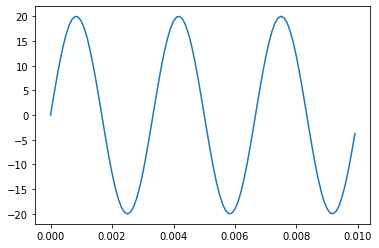

In [6]:
A = 20
fs = 1e4
n_segments = int(fs // 10)
fsig = 300
ii = int(fsig * n_segments // fs)  # frequency index of fsig

tt = np.arange(fs) / fs
x = A * np.sin(2 * np.pi * fsig * tt)
plt.plot(tt[:100],x[:100]);

**Assert Parseval's for different windowing functions**

Depending on the `scaling` flag, a different correction is applied to the windowed spectrum:

- `scaling='density'`: **Energy correction** - this corrects for the energy (integral) of the spectrum. It is typically applied to the power spectral density (including cross power spectral density) and rescales the spectrum by `1.0 / (window**2).mean()`. It ensures that the integral of the spectral density (approximately) matches the RMS$^2$ of the signal (i.e. that Parseval's theorem is satisfied).

- `scaling='spectrum'`: **Amplitude correction** - this corrects the amplitude of peaks in the spectrum and rescales the spectrum by `1.0 / window.mean()**2`. It is typically applied to the power spectrum (i.e. not density) and is most useful in strongly periodic signals. It ensures, for example, that the peak in the power spectrum of a 300 Hz sine wave with RMS$^2 = 200$ has a magnitude of $200$. 

These scalings replicate the [default behaviour of scipy spectral functions](https://github.com/scipy/scipy/blob/master/scipy/signal/tests/test_spectral.py#L485) like `scipy.signal.periodogram` and `scipy.signal.welch` (cf. [Section 11.5.2. of Bendat & Piersol, 2011](https://books.google.fr/books?hl=en&lr=lang_en%7Clang_ja&id=qYSViFRNMlwC&oi=fnd&pg=PT23&dq=Random+data:+analysis+and+measurement+procedures+(Vol.+729).+John+Wiley+%26+Sons.&ots=UcXMMJQVti&sig=6SbbMT9vhZ2V08EuO_Wx8x0UFnQ&redir_esc=y#v=onepage&q&f=false); [Section 10.3 of Brandt, 2011](https://books.google.fr/books?hl=en&lr=lang_en%7Clang_ja&id=-1DSxrlhL5sC&oi=fnd&pg=PT10&dq=Noise+and+vibration+analysis:+signal+analysis+and+experimental+procedures.+John+Wiley+%26+Sons.&ots=AKY9gnlRpj&sig=KY8v--GcRfIYkbMfJyAAiUXgfG8&redir_esc=y#v=onepage&q=Noise%20and%20vibration%20analysis%3A%20signal%20analysis%20and%20experimental%20procedures.%20John%20Wiley%20%26%20Sons.&f=false)).

In [7]:
RMS = np.sqrt(np.mean((x**2)))

windows = np.array([["hann","bartlett"],["tukey","flattop"]])

**Check the energy correction for `scaling='density'`**: With `window_correction=True`, the spectrum integrates to RMS$^2$.

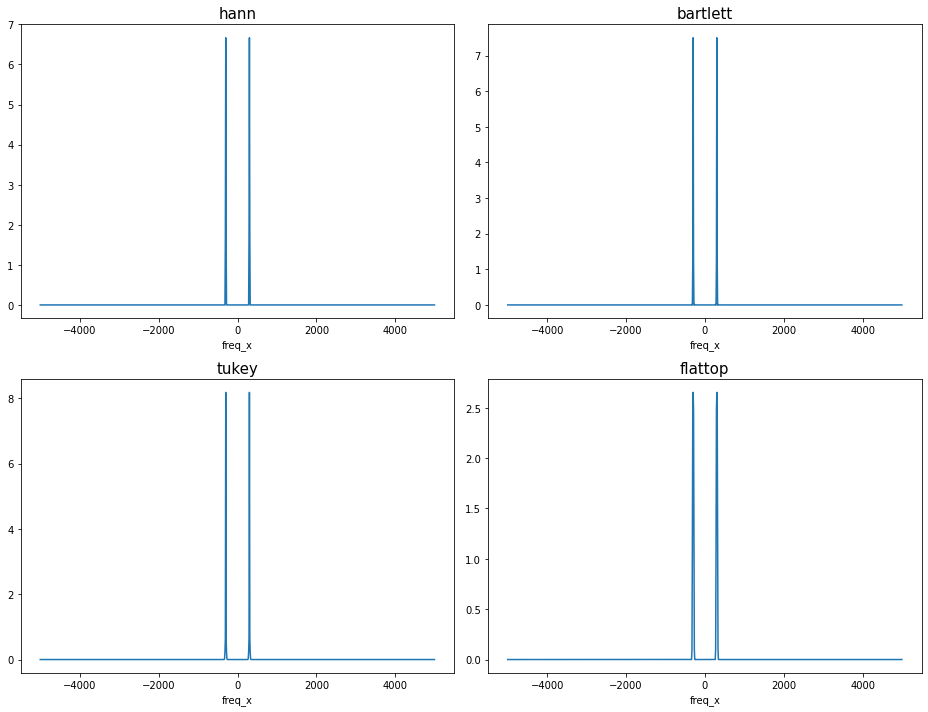

In [8]:
fig, axes = plt.subplots(figsize=(13,10), nrows=2, ncols=2)
fig.set_tight_layout(True)
    
for window_type in windows.ravel():

    x_da = xr.DataArray(x, coords=[tt], dims=["x"]).chunk({"x": n_segments})
    
    ps = xrft.power_spectrum(
        x_da,
        dim="x",
        window=window_type,
        chunks_to_segments=True,
        window_correction=True,
    ).mean("x_segment")
    
    ps.plot(ax=axes[np.where(windows==window_type)[0][0],np.where(windows==window_type)[1][0]])
    axes[np.where(windows==window_type)[0][0],np.where(windows==window_type)[1][0]].set_title(window_type, fontsize=15)
    
    npt.assert_allclose(
        np.trapz(ps.values, ps.freq_x.values),
        RMS**2,
        rtol=1e-3
    )

The maximum amplitude differs amongst cases with different windows due to the difference in noise floor.

**Check the amplitude correction for `scaling='spectrum'`**: With `window_correction=True`, the peak of the two-sided spectrum has a magnitude of RMS$^2/2$.


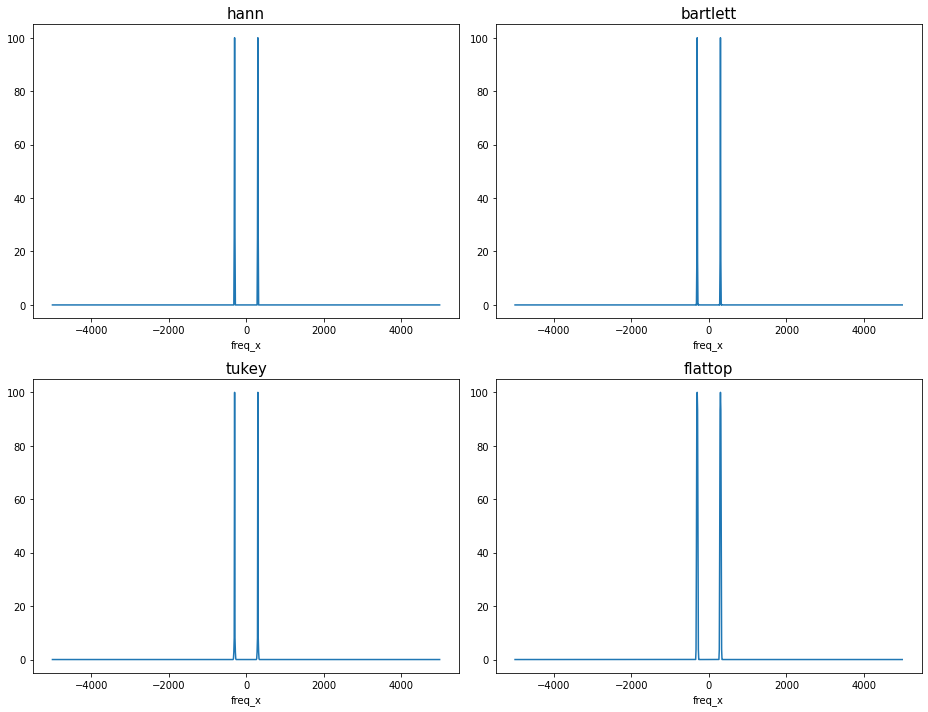

In [9]:
fig, axes = plt.subplots(figsize=(13,10), nrows=2, ncols=2)
fig.set_tight_layout(True)

for window_type in windows.ravel():

    x_da = xr.DataArray(x, coords=[tt], dims=["x"]).chunk({"x": n_segments})

    ps = xrft.power_spectrum(
        x_da,
        dim="x",
        window=window_type,
        chunks_to_segments=True,
        scaling="spectrum",
        window_correction=True,
    ).mean("x_segment")
    
    ps.plot(ax=axes[np.where(windows==window_type)[0][0],np.where(windows==window_type)[1][0]])
    axes[np.where(windows==window_type)[0][0],np.where(windows==window_type)[1][0]].set_title(window_type, fontsize=15)
    
    # The factor of 0.5 is there because we're checking the two-sided spectrum
    npt.assert_allclose(ps.sel(freq_x=fsig), 0.5 * RMS**2)

The maximum amplitudes are now all the same amongst different windows applied with the **amplitude correction**.